<a href="https://colab.research.google.com/github/nicholashagemann/DS-Assignment-Submission-Practice-Repository/blob/master/DS_Sprint_Challenge_22_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [2]:
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
"""T2. Create new feature"""
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df_i = pd.read_csv(url)
def wrangle(df):
  #dropping non-useful columns
  df.drop(columns = ['player_name', 'game_id', 'game_event_id', 'shot_zone_range'], 
          inplace = True)
  
  #engineering Homecourt Advantage
  df['home_adv'] = np.nan
  df.loc[df['htm'] == 'GSW', 'home_adv'] = 1
  df.loc[df['htm'] != 'GSW', 'home_adv'] = 0

  #engineering Opponent
  df['opponent'] = np.nan
  for i in range(len(df['htm'])):
    if df.loc[i, 'htm'] != 'GSW':
      df.loc[i, 'opponent'] = df.loc[i, 'htm']
    elif df.loc[i, 'vtm'] != 'GSW':
      df.loc[i, 'opponent'] = df.loc[i, 'vtm']
  df.drop(columns = ['vtm', 'htm'], inplace = True)

  #engineering Time Remaining in Period
  df['per_time_rem'] = np.nan
  for i in range(len(df['minutes_remaining'])):
    df.loc[i, 'per_time_rem'] = df.loc[i, 'minutes_remaining']*60 + df.loc[i, 'seconds_remaining']

  #engineering Total Time Remaining
  df['tot_time_rem'] = np.nan
  for i in range(len(df['minutes_remaining'])):
    df.loc[i, 'tot_time_rem'] = (4-df.loc[i, 'period'])*12*60 + df.loc[i, 'minutes_remaining']*60 + df.loc[i, 'seconds_remaining']
  df.drop(columns = ['period', 'minutes_remaining', 'seconds_remaining'], inplace = True)

  #engineering true_dist, the true distance from the hoop
  df['true_dist'] = np.nan
  df['loc_x'] = df['loc_x']/10
  df['loc_y'] = df['loc_y']/10
  for i in range(len(df['loc_x'])):
    df.loc[i, 'true_dist'] = (df.loc[i,'loc_x']**2 + df.loc[i,'loc_y']**2)**0.5
  df.drop(columns = ['loc_x', 'loc_y', 'shot_distance'], inplace = True)

  #engineering playoffs, whether or not a game is in the playoffs
  df['playoffs'] = np.nan
  df.loc[df['season_type'] == 'Regular Season', 'playoffs'] = 0
  df.loc[df['season_type'] == 'Playoffs', 'playoffs'] = 1
  df.drop(columns = ['season_type'], inplace = True)

  #check to make sure all of my values were correctly filled
  assert df.isna().sum().sum() == 0
  return df
df = wrangle(df_i)

In [4]:
#check if I need to clean up any NaN values
df_i.isna().sum().sum()

0

In [5]:
df_i.nunique()
#it looks like I can remove the player name column, since we're only looking at Steph Curry's data
#I'm going to drop the game_id and the game_event_id since they might confuse the data, 
  #and are very unlikely to have any predictive power
#shot_zone_range covers the same data with less specificity than shot_distance, get rid of it

action_type                  53
shot_type                     2
shot_zone_basic               7
shot_zone_area                6
shot_made_flag                2
game_date                   801
scoremargin_before_shot      79
home_adv                      2
opponent                     31
per_time_rem                713
tot_time_rem               2838
true_dist                  8070
playoffs                      2
dtype: int64

**Task 1 Testing**

In [6]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [9]:
#my ideas:
#convert htm and vtm into Homecourt Advantage and Opponent columns, then drop htm and vtm
#convert minutes and seconds column into per_time_rem column
#convert minutes, seconds, and period into tot_time_rem column
#drop minutes, seconds, and period columns
#'made previous shot' is the hot-hand fallacy, definitely won't use that
#I notice the shot_distance value is rounded
  #I can make a more precise measurement by applying Pythagorean Theorem to loc_x and loc_y
  #looks like it's always rounded down
  #loc_x and loc_y need to be divided by 10 to be in the same units as shot_distance
#change season type to playoffs, value of 0 for regular season and 1 for playoffs

In [ ]:
#I imported all features to the wrangle function above

In [7]:
print(df.shape)
print(df.select_dtypes('object').nunique())
#looks like we have enough data so the object cardinality isn't high enough for it to throw off predictions

(13958, 13)
action_type         53
shot_type            2
shot_zone_basic      7
shot_zone_area       6
game_date          801
opponent            31
dtype: int64


In [11]:
df['action_type'].unique()
#looks like we have jump shots, layup shots, bank shots, hook shots, tip shots, dunk shots, and combinations
#if we had less data I might try to make columns for each type of shot, but I think we have enough that it should
  #be able to make good predictions without feature engineering the action_type column

array(['Jump Shot', 'Step Back Jump shot', 'Pullup Jump shot',
       'Layup Shot', 'Jump Bank Shot', 'Driving Layup Shot',
       'Reverse Layup Shot', 'Running Jump Shot', 'Floating Jump shot',
       'Driving Finger Roll Layup Shot', 'Running Hook Shot',
       'Driving Reverse Layup Shot', 'Turnaround Jump Shot',
       'Fadeaway Jump Shot', 'Running Layup Shot', 'Running Bank shot',
       'Jump Hook Shot', 'Turnaround Bank shot', 'Driving Bank Hook Shot',
       'Running Reverse Layup Shot', 'Tip Shot', 'Fadeaway Bank shot',
       'Hook Shot', 'Pullup Bank shot', 'Finger Roll Layup Shot',
       'Slam Dunk Shot', 'Turnaround Fadeaway shot', 'Driving Dunk Shot',
       'Driving Jump shot', 'Hook Bank Shot', 'Driving Bank shot',
       'Running Bank Hook Shot', 'Putback Layup Shot', 'Dunk Shot',
       'Driving Hook Shot', 'Turnaround Bank Hook Shot',
       'Running Finger Roll Layup Shot', 'Running Slam Dunk Shot',
       'Driving Slam Dunk Shot', 'Turnaround Hook Shot',
       

In [12]:
df.head()

,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_made_flag,game_date,scoremargin_before_shot,home_adv,opponent,per_time_rem,tot_time_rem,true_dist,playoffs
0,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),0,2009-10-28,2.0,1.0,HOU,685.0,2845.0,26.795895,0.0
1,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),1,2009-10-28,0.0,1.0,HOU,571.0,2731.0,18.949670,0.0
2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),0,2009-10-28,-4.0,1.0,HOU,362.0,2522.0,14.227087,0.0
3,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),0,2009-10-28,-4.0,1.0,HOU,589.0,2029.0,19.054658,0.0
4,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),0,2009-10-28,0.0,1.0,HOU,139.0,1579.0,16.287418,0.0


**Task 2 Test**

In [ ]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [8]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag'
y = df[target]
X = df.drop(columns = target)

**Task 3 Test**

In [10]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [11]:
'''T4. Create training and val'''
# YOUR CODE HERE
cutoff1 = '2017-09-01'
cutoff2 = '2018-09-01'
X['game_date'] = pd.to_datetime(X['game_date'])
X_train = X[(X['game_date'] < cutoff1)]
mask1 = X_train.index
y_train = y[mask1]

X_val = X[(X['game_date'] > cutoff1) & (X['game_date'] < cutoff2)]
mask2 = X_val.index
y_val = y[mask2]

X_test = X[(X['game_date'] > cutoff2)]
mask3 = X_test.index
y_test = y[mask3]

X_train.drop(columns = 'game_date', inplace = True)
X_val.drop(columns = 'game_date', inplace = True)
X_test.drop(columns = 'game_date', inplace = True)

print(f'Lengths of training for X and y: {X_train.shape}, {y_train.shape}.')
print(f'Lengths of validation for X and y: {X_val.shape}, {y_val.shape}.')
print(f'Lengths of testing for X and y: {X_test.shape}, {y_test.shape}.')

Lengths of training for X and y: (11081, 11), (11081,).
Lengths of validation for X and y: (1168, 11), (1168,).
Lengths of testing for X and y: (1709, 11), (1709,).


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Test 4**

In [12]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [13]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y.value_counts(normalize = True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5270812437311936


**Task 5 Testing**

In [14]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [15]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(strategy = 'mean'),
                      RandomForestClassifier(random_state = 42,
                                             max_depth = 10,
                                             n_jobs = -1) )
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'opponent'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_

**Task 6 Testing**

In [16]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [17]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.725656529194116
Validation Accuracy Score: 0.6053082191780822


**Task 7 Test**

In [18]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [19]:
depths = np.arange(1, 30, 1)
train_acc_depth = []
val_acc_depth = []
for depth in depths:
  model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(strategy = 'mean'),
                      RandomForestClassifier(random_state = 42,
                                             max_depth = depth,
                                             n_jobs = -1) )
  model.fit(X_train, y_train)
  train_acc_depth.append(model.score(X_train, y_train))
  val_acc_depth.append(model.score(X_val, y_val))
depth_df = pd.DataFrame(list(zip(train_acc_depth, val_acc_depth)), index = depths, columns = ['training_accuracy', 'validation_accuracy'])
depth_df

,training_accuracy,validation_accuracy
1,0.586680,0.592466
2,0.648588,0.604452
3,0.650573,0.604452
4,0.664651,0.607877
5,0.672322,0.613014
6,0.676834,0.614726
7,0.681076,0.611301
8,0.693529,0.607021
9,0.707878,0.609589
10,0.725657,0.605308


In [20]:
estimators = np.arange(10, 300, 10)
train_acc_est = []
val_acc_est = []
for estimator in estimators:
  model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(strategy = 'mean'),
                      RandomForestClassifier(random_state = 42,
                                             max_depth = 6,
                                             n_estimators = estimator,
                                             n_jobs = -1) )
  model.fit(X_train, y_train)
  train_acc_est.append(model.score(X_train, y_train))
  val_acc_est.append(model.score(X_val, y_val))
est_df = pd.DataFrame(list(zip(train_acc_est, val_acc_est)), index = estimators, columns = ['training_accuracy', 'validation_accuracy'])
est_df

,training_accuracy,validation_accuracy
10,0.670517,0.609589
20,0.671781,0.609589
30,0.671510,0.610445
40,0.675661,0.609589
50,0.676112,0.612158
60,0.675390,0.609589
70,0.676022,0.612158
80,0.676112,0.614726
90,0.676203,0.613014
100,0.676834,0.614726


In [21]:
samples = np.arange(0.1, 1, 0.05)
train_acc_samp = []
val_acc_samp = []
for sample in samples:
  model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(strategy = 'mean'),
                      RandomForestClassifier(random_state = 42,
                                             max_depth = 6,
                                             n_estimators = 180,
                                             max_samples = sample,
                                             n_jobs = -1) )
  model.fit(X_train, y_train)
  train_acc_samp.append(model.score(X_train, y_train))
  val_acc_samp.append(model.score(X_val, y_val))
samp_df = pd.DataFrame(list(zip(train_acc_samp, val_acc_samp)), index = samples, columns=['training_accuracy', 'validation_accuracy'])
samp_df

,training_accuracy,validation_accuracy
0.10,0.671149,0.613870
0.15,0.673495,0.612158
0.20,0.674127,0.613014
0.25,0.674849,0.612158
0.30,0.673044,0.613014
0.35,0.673044,0.609589
0.40,0.672863,0.610445
0.45,0.672232,0.611301
0.50,0.673134,0.614726
0.55,0.674037,0.609589


In [22]:
'''T8. Tune model.'''

# YOUR CODE HERE
model_rf = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestClassifier(random_state = 42,
                                              max_depth = 6,
                                              n_estimators = 180,
                                              max_samples = 0.65,
                                              n_jobs = -1) )
model_rf.fit(X_train, y_train)

train_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)
test_acc = model_rf.score(X_test, y_test)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)
print('Testing Accuracy Score:', test_acc)

Training Accuracy Score: 0.6756610414222544
Validation Accuracy Score: 0.613013698630137
Testing Accuracy Score: 0.620245757753072


**Task 8 Testing**

In [23]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

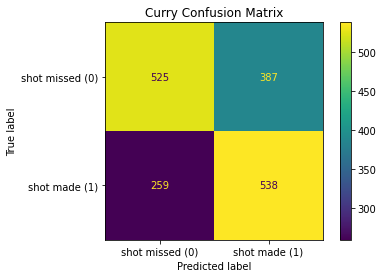

In [24]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
#Precision is TP/(TP+FP) and denotes what percentage of predictions our model thinks are true are actually true
#Recall is TP/(TP+FN) and denotes what percentage of true values our model predicted were true
#Since there is always a trade-off between False Negatives and False Positives, 
  #increasing precision will decrease recall, unless you can improve the model itself
instructor_precision = 538/(538+387)
instructor_recall = 538/(538+259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [25]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

In [29]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model_rf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

In [27]:
'''T10. Plot ROC curve.'''
from sklearn.metrics import roc_curve
# YOUR CODE HERE
y_pred_prob = model_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [28]:
roccurve_df = pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

roccurve_df.tail(10)

,False Positive Rate,True Positive Rate,Threshold
774,0.950658,0.994981,0.240856
775,0.955044,0.994981,0.237201
776,0.955044,0.996236,0.232912
777,0.957237,0.996236,0.230720
778,0.957237,0.997491,0.225838
779,0.964912,0.997491,0.216679
780,0.964912,0.998745,0.210458
781,0.991228,0.998745,0.150965
782,0.991228,1.000000,0.148225
783,1.000000,1.000000,0.037389
